In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, t, gaussian_kde
import numpy as np
from pybedtools import BedTool
from matplotlib.lines import Line2D
replicates=10

In [2]:
def linear_regression(x, y, full_range=False):
    reg = linregress(x, y)
    if not full_range:
        x2 = np.linspace(x.min(), x.max(), 100)
    else:
        x2 = np.linspace(min([x.min(), y.min()]), 
                         max([x.max(), y.max()]), 100)
    y2 = x2 * reg.slope + reg.intercept
#     https://github.com/BMClab/BMC/blob/0c338ecf74798379d724a0f27f399c96b7aecbe3//notebooks/CurveFitting.ipynb
    # Confidence interval for the linear fit:
    zscore = t.ppf(0.975, x.shape[0] - 2)
    s_err = s_err = np.sqrt(np.sum((y - (x * reg.slope + reg.intercept))**2)/(x.shape[0] - 2))
    ci = zscore * s_err * np.sqrt(1 / x.shape[0] + (x2 - np.mean(x))**2/np.sum((x2 - np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = zscore * s_err * np.sqrt(1 + 1 / x.shape[0] + (x2 - np.mean(x))**2 / np.sum((x2 - np.mean(x))**2))
#     print(f'Slope: {reg.slope} 95% CI: {reg.slope - reg.stderr * 1.96} - {reg.slope + reg.stderr * 1.96}')
#     print(f'Intercept: {reg.intercept} 95% CI: {reg.intercept - reg.intercept_stderr * 1.96} - {reg.intercept + reg.intercept_stderr * 1.96}')
    
    return reg.slope, reg.intercept, reg.rvalue, reg.pvalue, x2, y2, ci, pi
    
    
    return reg.slope, reg.intercept, reg.rvalue, reg.pvalue, x2, y2, ci, pi


def read_ibdmix_results(filename):
    ibdmix = pd.read_csv(filename, sep='\t', names=['chrom', 'start', 'end', "LOD", "IID", 
                                                      "pop", "super_pop"])
    ibdmix['length'] = (ibdmix.end - ibdmix.start)
    return ibdmix


def make_violinplot(amounts, position, ax, color, width=0.5, alpha=1):
    parts = ax.violinplot(amounts, showmedians=True, positions=[position], widths=width)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.1)
        pc.set_alpha(alpha)
    parts['cmedians'].set_color('black')
    parts['cmins'].set_color('black')
    parts['cmaxes'].set_color('black')
    parts['cbars'].set_color('black')
    return ax

def compare_amounts_predicted_introgressed_sequence_by_populations(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    amounts = df.groupby(['pop', 'IID']).sum().loc[:, 'length'] / 1e6
    super_pops = amounts.index.get_level_values(0).unique()
    n = 0
    xlabels = []
    for super_pop, color in zip(['EAS', 'EUR', 'AFR', 'AA'], 
                                ['green', 'blue', 'red', 'purple']):
        if super_pop in super_pops:
            c_amounts = amounts.loc[(super_pop, slice(None))]
        else:
            continue
        ax = make_violinplot(c_amounts, n, ax, color)
        n += 1
        xlabels.append(super_pop)
    ax.set_xticks(np.arange(0, len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=0)
    ax.set_ylabel(f'Amount introgressed per individual in Mb')
    return ax

def plot_haplotype_frequencies(df, column, chrom, ax, alpha, color):
    c_starts = df.loc[df.chrom == chrom, 'start'].values / 1e6
    c_freqs = df.loc[df.chrom == chrom, column].values
    c_ends = df.loc[df.chrom == chrom, 'end'].values / 1e6
    ax[chrom - 1].bar(c_starts, c_freqs, c_ends - c_starts, align='edge', color=color, alpha=alpha)
    return ax

def sort_individuals(df, K):
    """
    Sort individuals by modal ancestry components and it's intensity
    :param df: pd.DataFrame, data frame containing ancestry porportions
    :param K: int, K used to run admixture
    :return: pd.DataFrame, sorted df
    """
    # get mean ancestry per component for each population
    mean_ancestry_pops = df.groupby('population').mean()
    # identify modal component for each population, i.e., the component with the highest ancestry proportion
    modal_clusters_pops = mean_ancestry_pops.iloc[:, :-1].idxmax(axis=1).sort_values()
    individual_orders = []
    # iterate over all k
    for i in df.columns[:-1]:
        # get all populations for which the current component is model
        pops = modal_clusters_pops[modal_clusters_pops == i].index.values.tolist()
        # sort the population by they mean ancestry proportions of the modal component
        pops_sorted = mean_ancestry_pops.loc[pops, i].sort_values(ascending=False).index.values
        inds = []
        # sort the individuals within a population by ancestry proportion
        for pop in pops_sorted:
            inds.extend(df.loc[df.population == pop, i].sort_values(ascending=False).index.values.tolist())
        individual_orders.extend(inds)

    df = df.loc[individual_orders, :]
    return df


def plot_admixture_proportions(df, K, ax=None):
    """
    Create horizontal bar plot of ADMIXTURE results
    :param df: pd.DataFrame, sorted DataFrame with ancestry proportions
    :param K: int, K used for admixture run
    """
    colors = ["red", "green", "blue", 'orange']
    # pad colors
    while K > len(colors):
        colors.append((np.random.random(), np.random.random(), np.random.random()))
    if ax is None:
        fig, ax = plt.subplots(figsize=(2, 8))
    populations = df.population.values
    y_coords = [0]
    y_ticks = []
    y_labels = []
    prev_pop = populations[0]
    pop_coord_start = 0
    cumulative_padding = 0
    padding = 2
    for i, pop in enumerate(populations[1:], 1):
        if prev_pop != pop:
            # get ytick positions and labels
            y_ticks.append((pop_coord_start + i + cumulative_padding - 1) / 2)
            y_labels.append(prev_pop)
            prev_pop = pop
            # add white space between populations
            cumulative_padding += padding
            pop_coord_start = i + cumulative_padding
        # determine y coords --> add white space between populations
        y_coords.append(i + cumulative_padding)
    y_ticks.append((pop_coord_start + i + cumulative_padding) / 2)
    y_labels.append(prev_pop)
    prev_k = []
    # do plotting
    for i, anc in enumerate(df.columns[:-1]):
        if i > 0:
            ax.barh(y_coords, df.loc[:, anc], left=df.loc[:, prev_k].sum(axis=1), height=1, color=colors[i])
        else:
            ax.barh(y_coords, df.loc[:, anc], height=1, color=colors[i])
        prev_k.append(anc)
    # formatting
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=10)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_xticklabels(['{:.1f}'.format(tick) for tick in np.arange(0, 1.2, 0.2)], rotation=90)
    
    ax.invert_yaxis()
    ax.set_xlabel(f"K={K}", fontsize=12)
    ax.set_ylim([len(populations) + cumulative_padding - 0.5, -0.5])
    ax.set_xlim([0, 1])
    return ax 


# Single pulse

### Global ancestry proportions

#### Global ancestry proportions

In [3]:
admixture_proportions_replicates = []
K=3
for replicate in range(0, replicates):
    admixture_proportions = pd.read_csv(f'simulations_exp_ref/ALL_chromosomes_replicate_{replicate}_ancestry_proportions-20.3.Q',
                                        sep='\t')
    afr_iid = pd.read_csv(f'simulations_exp_ref/AFR_sample_ids_replicate{replicate}.txt', names=['iid'])
    afr_iid['fid'] = 'AFR'
    eur_iid = pd.read_csv(f'simulations_exp_ref/EUR_sample_ids_replicate{replicate}.txt', names=['iid'])
    eur_iid['fid'] = 'EUR'
    eas_iid = pd.read_csv(f'simulations_exp_ref/EAS_sample_ids_replicate{replicate}.txt', names=['iid'])
    eas_iid['fid'] = 'EAS'
    aa_iid = pd.read_csv(f'simulations_exp_ref/AA_sample_ids_replicate{replicate}.txt', names=['iid'])
    aa_iid['fid'] = 'AA'
    fam = pd.concat([afr_iid, eur_iid, eas_iid, aa_iid])
    admixture_proportions = admixture_proportions.join(fam.set_index('iid')) 
    admixture_proportions.rename(columns={'fid': "population", 'African': 'AFR', 
                                          'European': 'EUR', 'EastAsian': 'EAS'}, inplace=True)
#     df_sorted = sort_individuals(admixture_proportions, K)
#     plot_admixture_proportions(df_sorted, K, ax[replicate])
    admixture_proportions_replicates.append(admixture_proportions)


### Introgression amounts

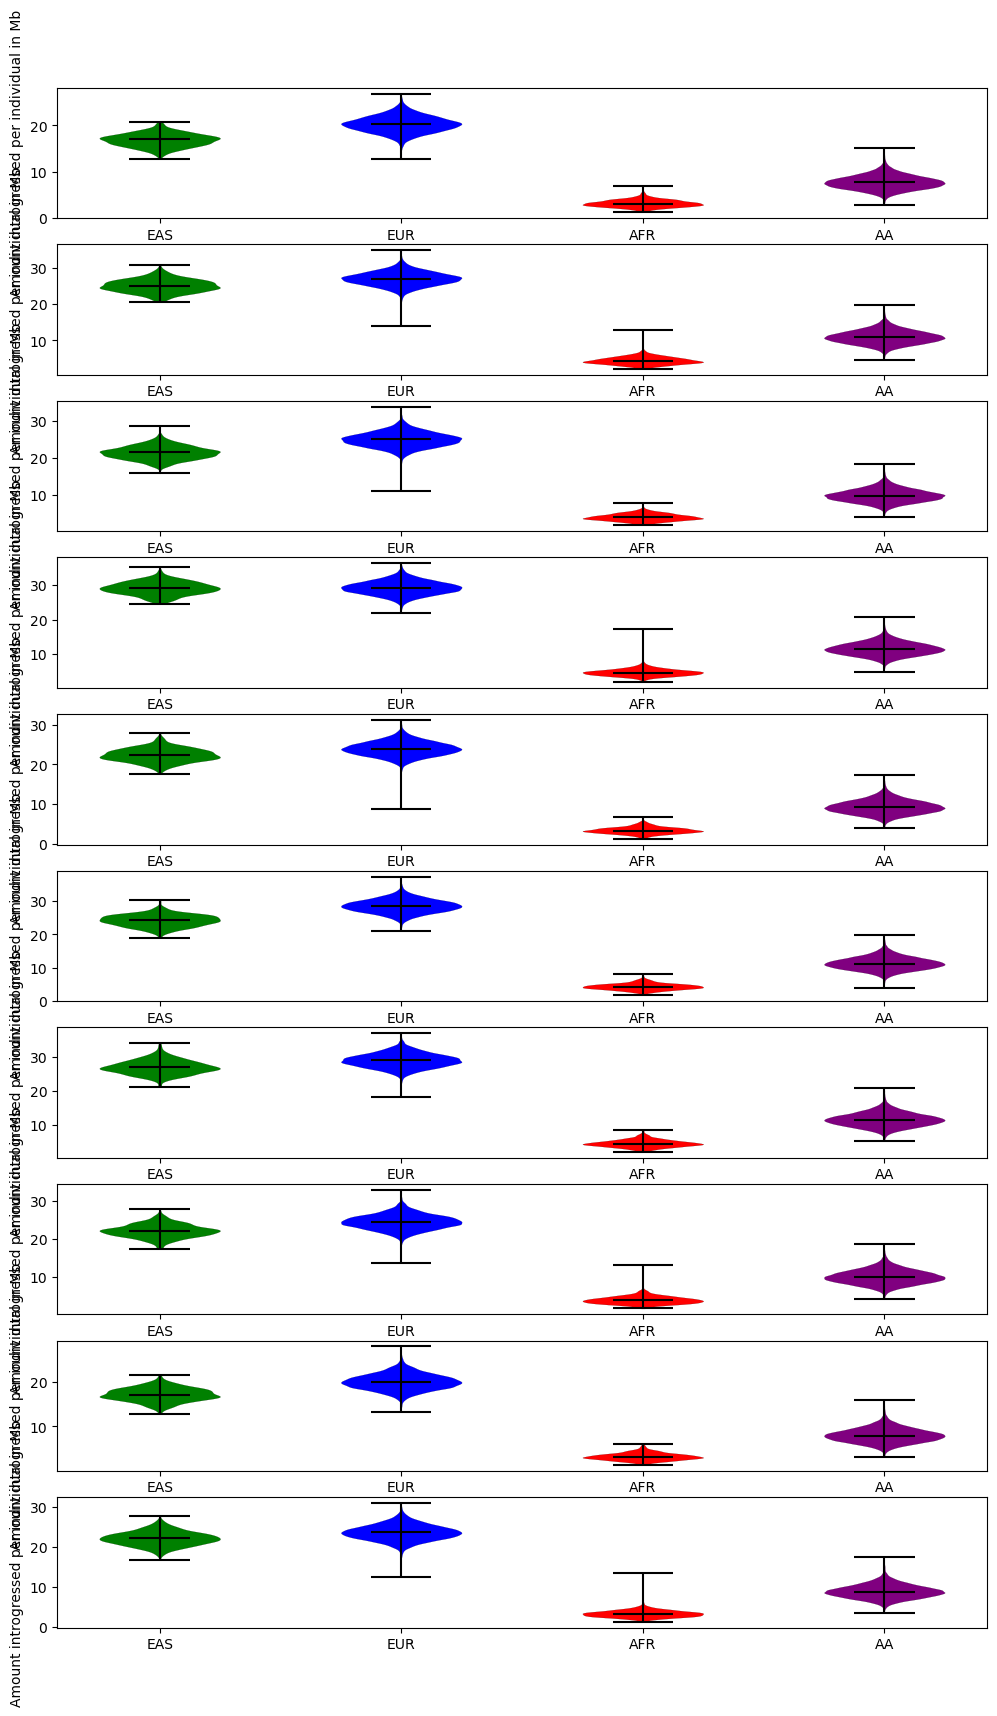

In [4]:
def read_ibdmix_sim(fn):
    introgressed_segments = read_ibdmix_results(fn)
    introgressed_segments['end'] = np.where((introgressed_segments.end > 31000000) & 
                                            (introgressed_segments.start < 31000000), 31000000, 
                                            introgressed_segments.end)    
    introgressed_segments['start'] = np.where((introgressed_segments.start < 47000000) & 
                                        (introgressed_segments.end > 47000000), 47000000, 
                                        introgressed_segments.start)
    introgressed_segments = introgressed_segments[(introgressed_segments.end <= 31000000) | 
                                                  (introgressed_segments.start >= 47000000)] 
    
    introgressed_segments['length'] = introgressed_segments.end - introgressed_segments.start
    introgressed_segments = introgressed_segments[introgressed_segments['length'] >= 50000] 
    return introgressed_segments

introgressed_segments_replicates = []
introgressed_segments_afr_masked_replicates = []
fig, ax = plt.subplots(10, 1, figsize=(12, 20))

for replicate in range(replicates):
    introgressed_segments = read_ibdmix_sim(f'simulations_exp_ref/neanderthal_introgressed_segments_masked_denisovan_replicate_{replicate}.bed')
    introgressed_segments_replicates.append(introgressed_segments)
    introgressed_segments_afr_masked = read_ibdmix_sim(f'simulations_exp_ref/neanderthal_introgressed_segments_masked_denisovan_replicate_{replicate}_afr_masked.bed')
    introgressed_segments_afr_masked_replicates.append(introgressed_segments_afr_masked)
    
    if replicate < 10:
        compare_amounts_predicted_introgressed_sequence_by_populations(introgressed_segments, ax[replicate])

In [5]:
def calculate_expected_introgression(admixture_proportions, ibdmix):
    # calculate introgressed amount per individual
    amounts = ibdmix.groupby('IID').sum().loc[:, ['length']] / 1e6
    # join with admixture proportions
    amounts = amounts.join(admixture_proportions)
    # select admixed individuals only
    amounts = amounts[amounts.population == 'AA']
    super_pop_indv_mapping = ibdmix.drop_duplicates("IID").loc[:, ["IID", 'super_pop']].set_index('IID')
    # groupby individual
    amount_introgression_per_indv = ibdmix.loc[:, ['IID', 'length']].groupby('IID').sum() / 1e6
    # calculate mean per continental population
    amount_introgression_superpop_per_indv = super_pop_indv_mapping.join(amount_introgression_per_indv)
    mean_introgression_per_superpop = amount_introgression_superpop_per_indv.groupby('super_pop').mean()
    if not 'AFR' in mean_introgression_per_superpop.index:
        mean_introgression_per_superpop.loc['AFR', 'length'] = 0.0
    if not 'EUR' in mean_introgression_per_superpop.index:
        mean_introgression_per_superpop.loc['EUR', 'length'] = 0.0
    if not 'EAS' in mean_introgression_per_superpop.index:
        mean_introgression_per_superpop.loc['EAS', 'length'] = 0.0
    amounts['expected_introgression'] = (amounts.AFR * 
                                         mean_introgression_per_superpop.loc['AFR', 'length'] + 
                                         amounts.EUR * 
                                         mean_introgression_per_superpop.loc['EUR', 'length'] +
                                         amounts.EAS * 
                                         mean_introgression_per_superpop.loc['EAS', 'length'])
        
    return amounts

def get_enrichment_by_segment_length(admixture, ibdmix):
    amounts = calculate_expected_introgression(admixture, ibdmix)
    amounts_short = calculate_expected_introgression(admixture, ibdmix[ibdmix['length'] <= 0.8e5])
    amounts_medium = calculate_expected_introgression(admixture, ibdmix[(ibdmix['length'] > 0.8e5) &
                                                                        (ibdmix['length'] <= 2.5e5)])
    amounts_long = calculate_expected_introgression(admixture, ibdmix[ibdmix['length'] > 2.5e5])
    
    return amounts, amounts_short, amounts_medium, amounts_long

def save_summary_stats(ibdmix_replicates, admixture_proportion_replicates, prefix):
    ratios = []
    ratios_short = []
    ratios_medium = []
    ratios_long = []
    differences = []
    differences_short = []
    differences_medium = []
    differences_long = []
    slopes = []
    intercepts = []
    lengths = []
    lods = []
    for ibdmix, admixture_proportion in zip(ibdmix_replicates, admixture_proportion_replicates):
#         for chrom in np.arange(1, 11):
        (amounts, amounts_short, amounts_medium, 
         amounts_long) = get_enrichment_by_segment_length(admixture_proportion, ibdmix)
        (slope, intercept, rvalue, pvalue, 
         x2, y2, ci, pi) = linear_regression(amounts.expected_introgression,
                                             amounts['length'], full_range=True)
        ratios.append(np.log10(amounts['length'].values / 
                               amounts['expected_introgression'].values))
        ratios_short.append(np.log10(amounts_short['length'].values / 
                                     amounts_short['expected_introgression'].values))
        ratios_medium.append(np.log10(amounts_medium['length'].values / 
                                      amounts_medium['expected_introgression'].values))
        ratios_long.append(np.log10(amounts_long['length'].values / 
                                    amounts_long['expected_introgression'].values))
        differences.append(amounts['length'].values - 
                           amounts['expected_introgression'].values)
        differences_short.append(amounts_short['length'].values - 
                                 amounts_short['expected_introgression'].values)
        differences_medium.append(amounts_medium['length'].values - 
                                  amounts_medium['expected_introgression'].values)
        differences_long.append(amounts_long['length'].values - 
                                amounts_long['expected_introgression'].values)
        lengths.append(ibdmix['length'].values)
        lods.append(ibdmix['LOD'].values)
        slopes.append(slope)
        intercepts.append(intercept)
#     return (ratios, ratios_short, ratios_medium, ratios_long, differences, 
#             differences_short, differences_medium, differences_long, slopes, intercepts, lengths, lods)
    np.savez(f'{prefix}_ratios.npz', np.array(ratios, dtype=object))
    np.savez(f'{prefix}_ratios_short_segments.npz', np.array(ratios_short, dtype=object))
    np.savez(f'{prefix}_ratios_medium_segments.npz', np.array(ratios_medium, dtype=object))
    np.savez(f'{prefix}_ratios_long_segments.npz', np.array(ratios_long, dtype=object))

    np.savez(f'{prefix}_differences.npz', np.array(differences, dtype=object))
    np.savez(f'{prefix}_differences_short_segments.npz', np.array(differences_short, dtype=object))
    np.savez(f'{prefix}_differences_medium_segments.npz', np.array(differences_medium, dtype=object))
    np.savez(f'{prefix}_differences_long_segments.npz', np.array(differences_long, dtype=object))
    np.savez(f'{prefix}_segment_lengths.npz', np.array(lengths, dtype=object))
    np.savez(f'{prefix}_segment_lods.npz', np.array(lods, dtype=object))
    np.savez(f'{prefix}_slopes.npz', np.array(slopes, dtype=object))
    np.savez(f'{prefix}_intercepts.npz', np.array(intercepts, dtype=object))


In [6]:
save_summary_stats(introgressed_segments_replicates, admixture_proportions_replicates, 'simulations')

In [7]:
save_summary_stats(introgressed_segments_afr_masked_replicates, admixture_proportions_replicates, 'simulations_afr_masked')

/scratch/190794/ipykernel_7799/3534644856.py:58: RuntimeWarning: divide by zero encountered in divide
  ratios.append(np.log10(amounts['length'].values /
/scratch/190794/ipykernel_7799/3534644856.py:60: RuntimeWarning: divide by zero encountered in divide
  ratios_short.append(np.log10(amounts_short['length'].values /
/scratch/190794/ipykernel_7799/3534644856.py:62: RuntimeWarning: divide by zero encountered in divide
  ratios_medium.append(np.log10(amounts_medium['length'].values /
/scratch/190794/ipykernel_7799/3534644856.py:64: RuntimeWarning: divide by zero encountered in divide
  ratios_long.append(np.log10(amounts_long['length'].values /


In [8]:

genetic_maps = []
for chrom in np.arange(1, 11):
    genetic_map = pd.read_csv(f'data/hapmap_genetic_map/genetic_map_Hg38_chr16.txt', sep='\t')
    genetic_map.rename({'Chromosome': 'chrom_map', 'Position(bp)': 'end_map', 'Rate(cM/Mb)': 'rate'}, 
                       axis=1, 
                       inplace=True)
    genetic_map['start_map'] = np.concatenate([[0], genetic_map.end_map[:-1]])
    genetic_map = genetic_map.loc[:, ['chrom_map', 'start_map', 'end_map', 'rate']]
    genetic_maps.append(genetic_map)
genetic_map = pd.concat(genetic_maps)
genetic_map['chrom_map'] = [chrom.replace('chr', '') for chrom in genetic_map.chrom_map.values]
chrom_sizes = pd.read_csv('simulations_exp_ref/genomefile_replicate_0.bed', sep='\t', 
                          names=['chrom', 'end'])
chrom_sizes['start'] = 0
chrom_sizes = chrom_sizes.loc[:, ['chrom', 'start', 'end']]
windows = BedTool.from_dataframe(chrom_sizes).window_maker(
    w=300000, 
    g='simulations_exp_ref/genomefile_replicate_0.bed')
columns = ['chrom', 'start', 'end']
columns.extend(genetic_map.columns.values.tolist())
columns.append('overlap')
rec_windows = windows.intersect(BedTool.from_dataframe(genetic_map), wao=True).to_dataframe(names=columns)
rec_windows.rate = np.where(rec_windows.rate == '.', '0', rec_windows.rate)
rec_windows.rate = rec_windows.rate.astype(float)
rec_windows['rate'] *= rec_windows['overlap']
rec_windows = rec_windows.loc[:,['chrom', 'start', 'end', 
                                 'rate', 'overlap']].groupby(['chrom', 'start', 'end']).sum()
rec_windows.rate /= rec_windows.overlap
rec_windows.reset_index(inplace=True)
rec_windows.fillna(0, inplace=True)
low_rec_thresh = np.percentile(rec_windows.rate.values, 33)
high_rec_thresh = np.percentile(rec_windows.rate.values, 66)
pass_rec_filter = rec_windows.loc[(rec_windows.rate >= low_rec_thresh) & 
                                  (rec_windows.rate <= high_rec_thresh), ['chrom', 'start', 'end']]


In [9]:
introgressed_segments_recomb_masked_replicates = []
for introgressed_segments in introgressed_segments_replicates:
    ibdmix_masked = BedTool.from_dataframe(introgressed_segments).intersect(
            BedTool.from_dataframe(pass_rec_filter), f=1).to_dataframe(names=introgressed_segments.columns)
    introgressed_segments_recomb_masked_replicates.append(ibdmix_masked)

In [10]:
save_summary_stats(introgressed_segments_recomb_masked_replicates, 
                   admixture_proportions_replicates, 'simulations_recomb_masked')

In [11]:
introgressed_segments_afr_recomb_masked_replicates = []
for introgressed_segments in introgressed_segments_afr_masked_replicates:
    ibdmix_masked = BedTool.from_dataframe(introgressed_segments).intersect(
            BedTool.from_dataframe(pass_rec_filter), f=1).to_dataframe(names=introgressed_segments.columns)
    introgressed_segments_afr_recomb_masked_replicates.append(ibdmix_masked)

In [12]:
save_summary_stats(introgressed_segments_afr_recomb_masked_replicates, 
                   admixture_proportions_replicates, 'simulations_afr_recomb_masked')

/scratch/171115/ipykernel_44985/3534644856.py:58: RuntimeWarning: divide by zero encountered in divide
  ratios.append(np.log10(amounts['length'].values /
/scratch/171115/ipykernel_44985/3534644856.py:60: RuntimeWarning: divide by zero encountered in divide
  ratios_short.append(np.log10(amounts_short['length'].values /
/scratch/171115/ipykernel_44985/3534644856.py:62: RuntimeWarning: divide by zero encountered in divide
  ratios_medium.append(np.log10(amounts_medium['length'].values /
/scratch/171115/ipykernel_44985/3534644856.py:58: RuntimeWarning: divide by zero encountered in divide
  ratios.append(np.log10(amounts['length'].values /
/scratch/171115/ipykernel_44985/3534644856.py:60: RuntimeWarning: divide by zero encountered in divide
  ratios_short.append(np.log10(amounts_short['length'].values /
/scratch/171115/ipykernel_44985/3534644856.py:62: RuntimeWarning: divide by zero encountered in divide
  ratios_medium.append(np.log10(amounts_medium['length'].values /
/scratch/171115/ip

##### Local ancestry

In [11]:
local_ancestry_replicates = []
local_ancestry_super_replicates = []

for replicate in range(replicates):
    c_local_ancestry = []
    for chrom in range(1, 11):
        local_ancestry_0 = pd.read_csv(f'simulations_exp_ref/chr{chrom}_local_ancestry_information_replicate_{replicate}_phase0.bed',
                                                sep='\t') 
        local_ancestry_1 = pd.read_csv(f'simulations_exp_ref/chr{chrom}_local_ancestry_information_replicate_{replicate}_phase1.bed',
                                                sep='\t')
        local_ancestry = pd.concat([local_ancestry_0, local_ancestry_1]).sort_values(['chrom', 'start', 'end'])
        local_ancestry['length'] = local_ancestry.end - local_ancestry.start
        c_local_ancestry.append(local_ancestry)
    local_ancestry = pd.concat(c_local_ancestry)
    local_ancestry_grouped = local_ancestry.groupby(['IID', 'la']).sum().loc[:, 'length']
    local_ancestry_grouped /= local_ancestry.groupby(['IID']).sum().loc[:, 'length']
    local_ancestry_grouped = pd.DataFrame(local_ancestry_grouped)
    local_ancestry_afr = local_ancestry_grouped.loc[pd.IndexSlice[:, 'AFR'], :].rename(columns={'length': 'AFR'})
    local_ancestry_eas = local_ancestry_grouped.loc[pd.IndexSlice[:, 'EAS'], :].rename(columns={'length': 'EAS'})
    local_ancestry_eur = local_ancestry_grouped.loc[pd.IndexSlice[:, 'EUR'], :].rename(columns={'length': 'EUR'})
    local_ancestry_afr = local_ancestry_afr.droplevel('la')
    local_ancestry_eas = local_ancestry_eas.droplevel('la')
    local_ancestry_eur = local_ancestry_eur.droplevel('la')

    local_ancestry_super = local_ancestry_afr.join(local_ancestry_eas).join(local_ancestry_eur)
    local_ancestry_super.fillna(0.0, inplace=True)
    local_ancestry_super['population'] = 'AA'
    local_ancestry_super_replicates.append(local_ancestry_super)
    local_ancestry_replicates.append(local_ancestry)    

###### Local vs global ancestry proportions

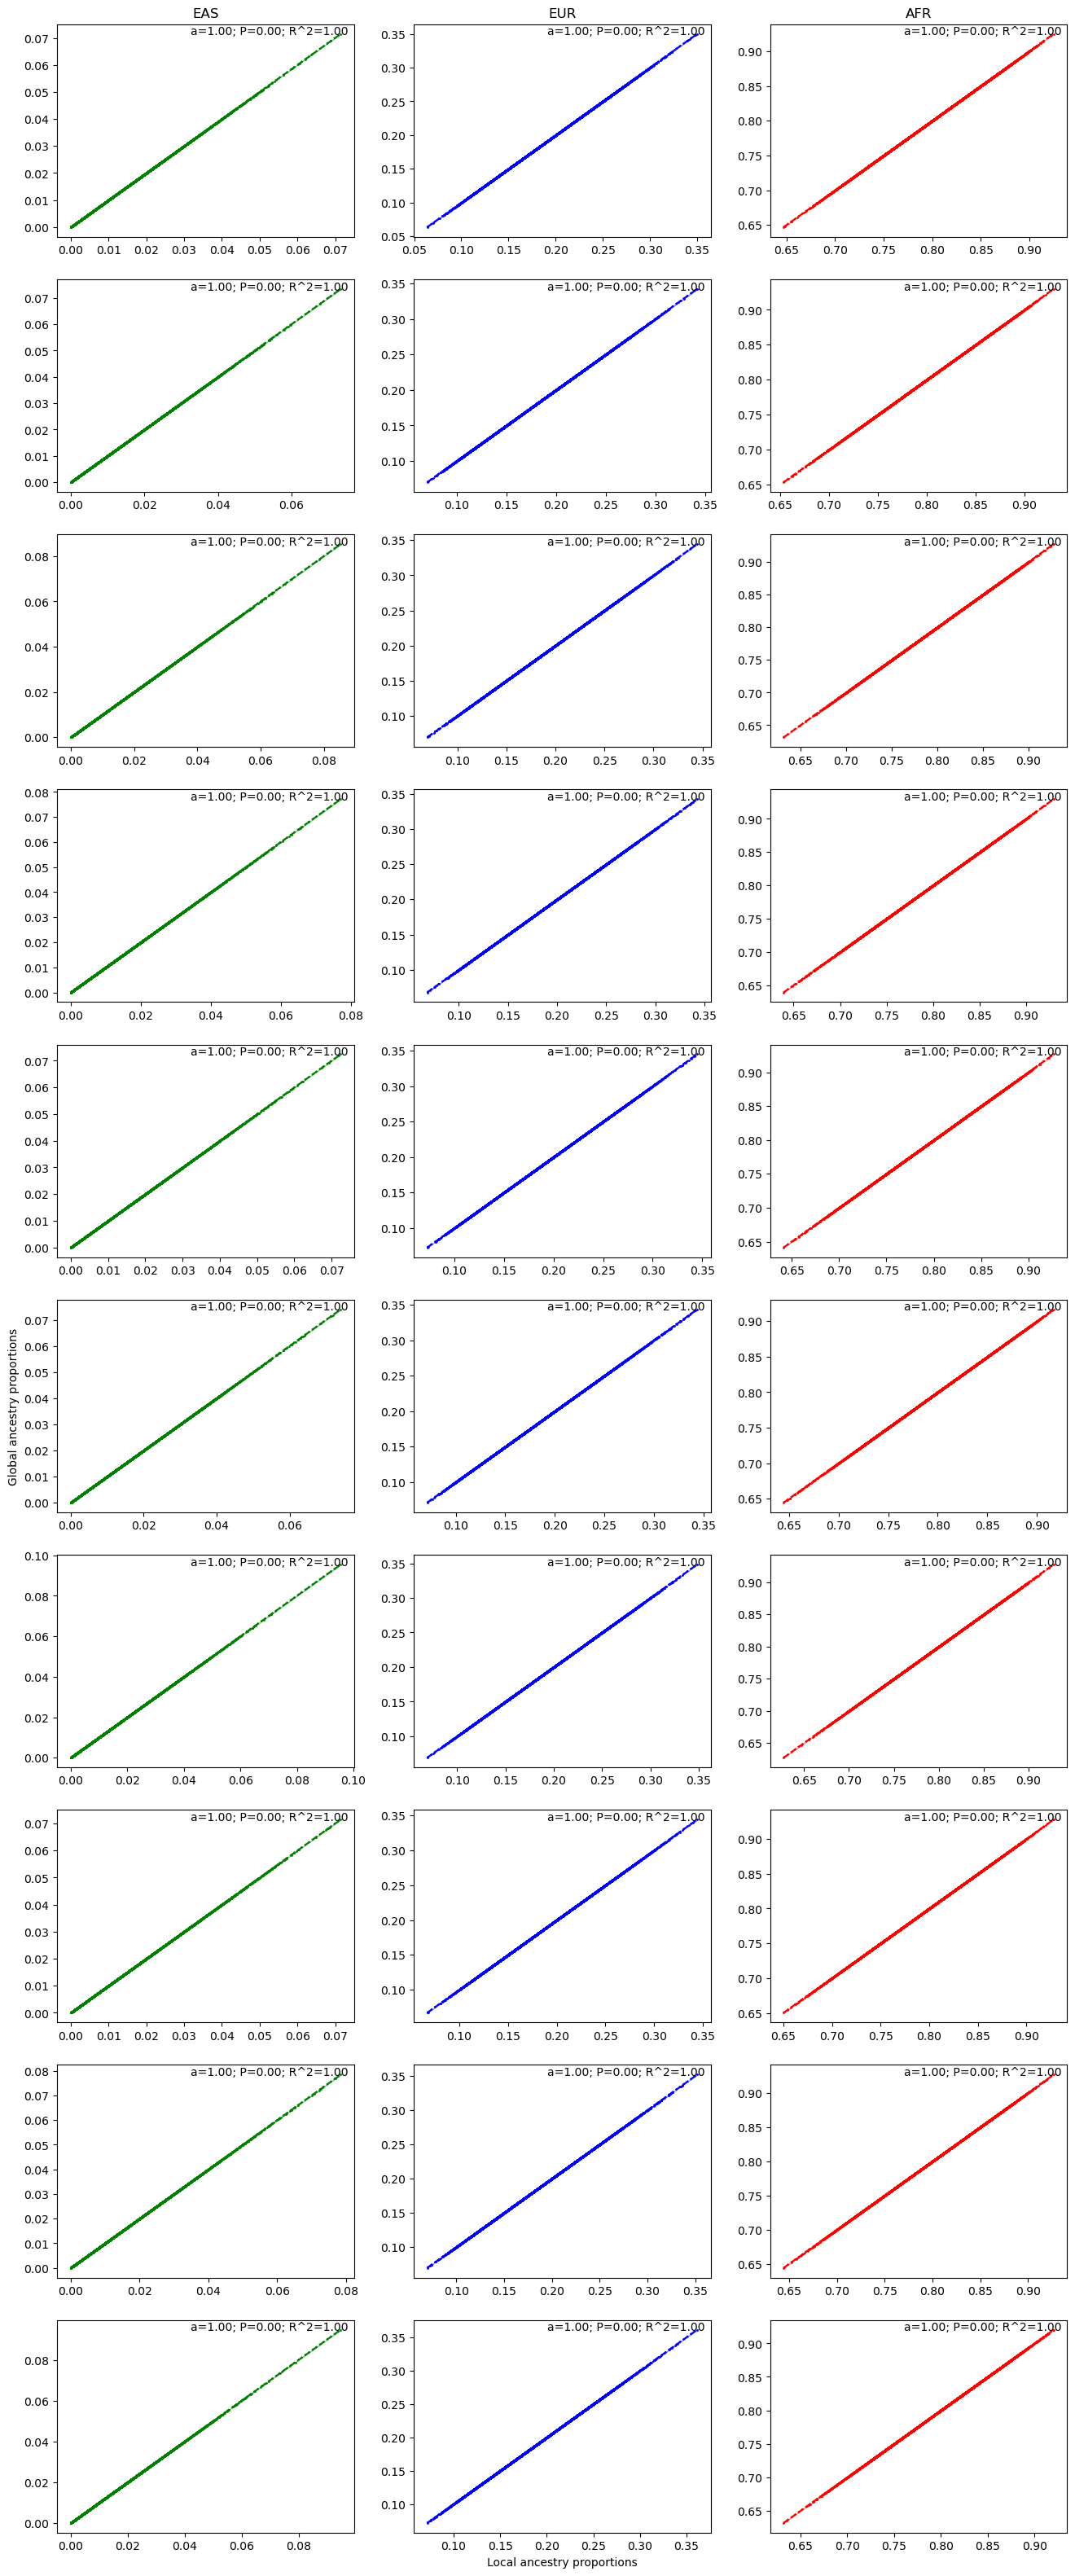

In [16]:
fig, ax = plt.subplots(replicates, 3, figsize=(16, 40))
ax[0, 0].set_title('EAS')
ax[0, 1].set_title('EUR')
ax[0, 2].set_title('AFR')
ax[replicates - 1, 1].set_xlabel('Local ancestry proportions')
ax[replicates // 2, 0].set_ylabel('Global ancestry proportions')

for i, (df_sorted, local_ancestry_super) in enumerate(zip(admixture_proportions_replicates, 
                                                          local_ancestry_super_replicates)):
    df_global_local = df_sorted.join(local_ancestry_super, rsuffix='_local', lsuffix='_global').dropna()
    try:
        (slope_eas, intercept_eas, rval_eas, 
         pval_eas, x_model_eas, y_model_eas, ci_eas, pi_eas) = linear_regression(df_global_local.EAS, 
                                                                         df_global_local.EAS)
    except ValueError:
        (slope_eas, intercept_eas, rval_eas, 
         pval_eas, x_model_eas, y_model_eas, ci_eas, pi_eas) = (0, 0, 0, 0, 0, 0, 0, 0)
    (slope_eur, intercept_eur, rval_eur, 
     pval_eur, x_model_eur, y_model_eur, ci_eur, pi_eur) = linear_regression(df_global_local.EUR, 
                                                                     df_global_local.EUR)
    (slope_afr, intercept_afr, rval_afr, 
     pval_afr, x_model_afr, y_model_afr, ci_afr, pi_afr) = linear_regression(df_global_local.AFR, 
                                                                     df_global_local.AFR)
    ax[i, 0].scatter(df_global_local.EAS, df_global_local.EAS, s=1, c='green')
    ax[i, 0].plot(x_model_eas, y_model_eas, ls='--', color='green')
    try:
        ax[i, 0].fill_between(x_model_eas, y_model_eas + ci_eas, y_model_eas - ci_eas, color="green", 
                              alpha=0.4)
    except IndexError:
        pass
    ax[i, 0].annotate('a={:.2f}; P={:.2f}; R^2={:.2f}'.format(slope_eas, pval_eas, rval_eas ** 2), (1, 1), 
                   (0.45, 0.95), xycoords='axes fraction')
    ax[i, 0].plot(x_model_eas, y_model_eas + pi_eas, ls=':', color='green')
    ax[i, 0].plot(x_model_eas, y_model_eas - pi_eas, ls=':', color='green')
    
    ax[i, 1].scatter(df_global_local.EUR, df_global_local.EUR, s=1, c='blue')
    ax[i, 1].plot(x_model_eur, y_model_eur, ls='--', color='blue')
    ax[i, 1].fill_between(x_model_eur, y_model_eur + ci_eur, y_model_eur - ci_eur, color="blue", alpha=0.4)

    ax[i, 1].annotate('a={:.2f}; P={:.2f}; R^2={:.2f}'.format(slope_eur, pval_eur, rval_eur ** 2), (1, 1),
                   (0.45, 0.95), xycoords='axes fraction')
    ax[i, 1].plot(x_model_eur, y_model_eur + pi_eur, ls=':', color='blue')
    ax[i, 1].plot(x_model_eur, y_model_eur - pi_eur, ls=':', color='blue')
    
    ax[i, 2].scatter(df_global_local.AFR, df_global_local.AFR, s=1, c='red')
    ax[i, 2].plot(x_model_afr, y_model_afr, ls='--', color='red')
    ax[i, 2].fill_between(x_model_afr, y_model_afr + ci_afr, y_model_afr - ci_afr, color="red", alpha=0.4)
    ax[i, 2].annotate('a={:.2f}; P={:.2f}; R^2={:.2f}'.format(slope_afr, pval_afr, rval_afr ** 2), (1, 1), 
                   (0.45, 0.95), xycoords='axes fraction')
    ax[i, 2].plot(x_model_afr, y_model_afr + pi_afr, ls=':', color='red')
    ax[i, 2].plot(x_model_afr, y_model_afr - pi_afr, ls=':', color='red')
    

#### Observed introgression amounts vs admixture proportions

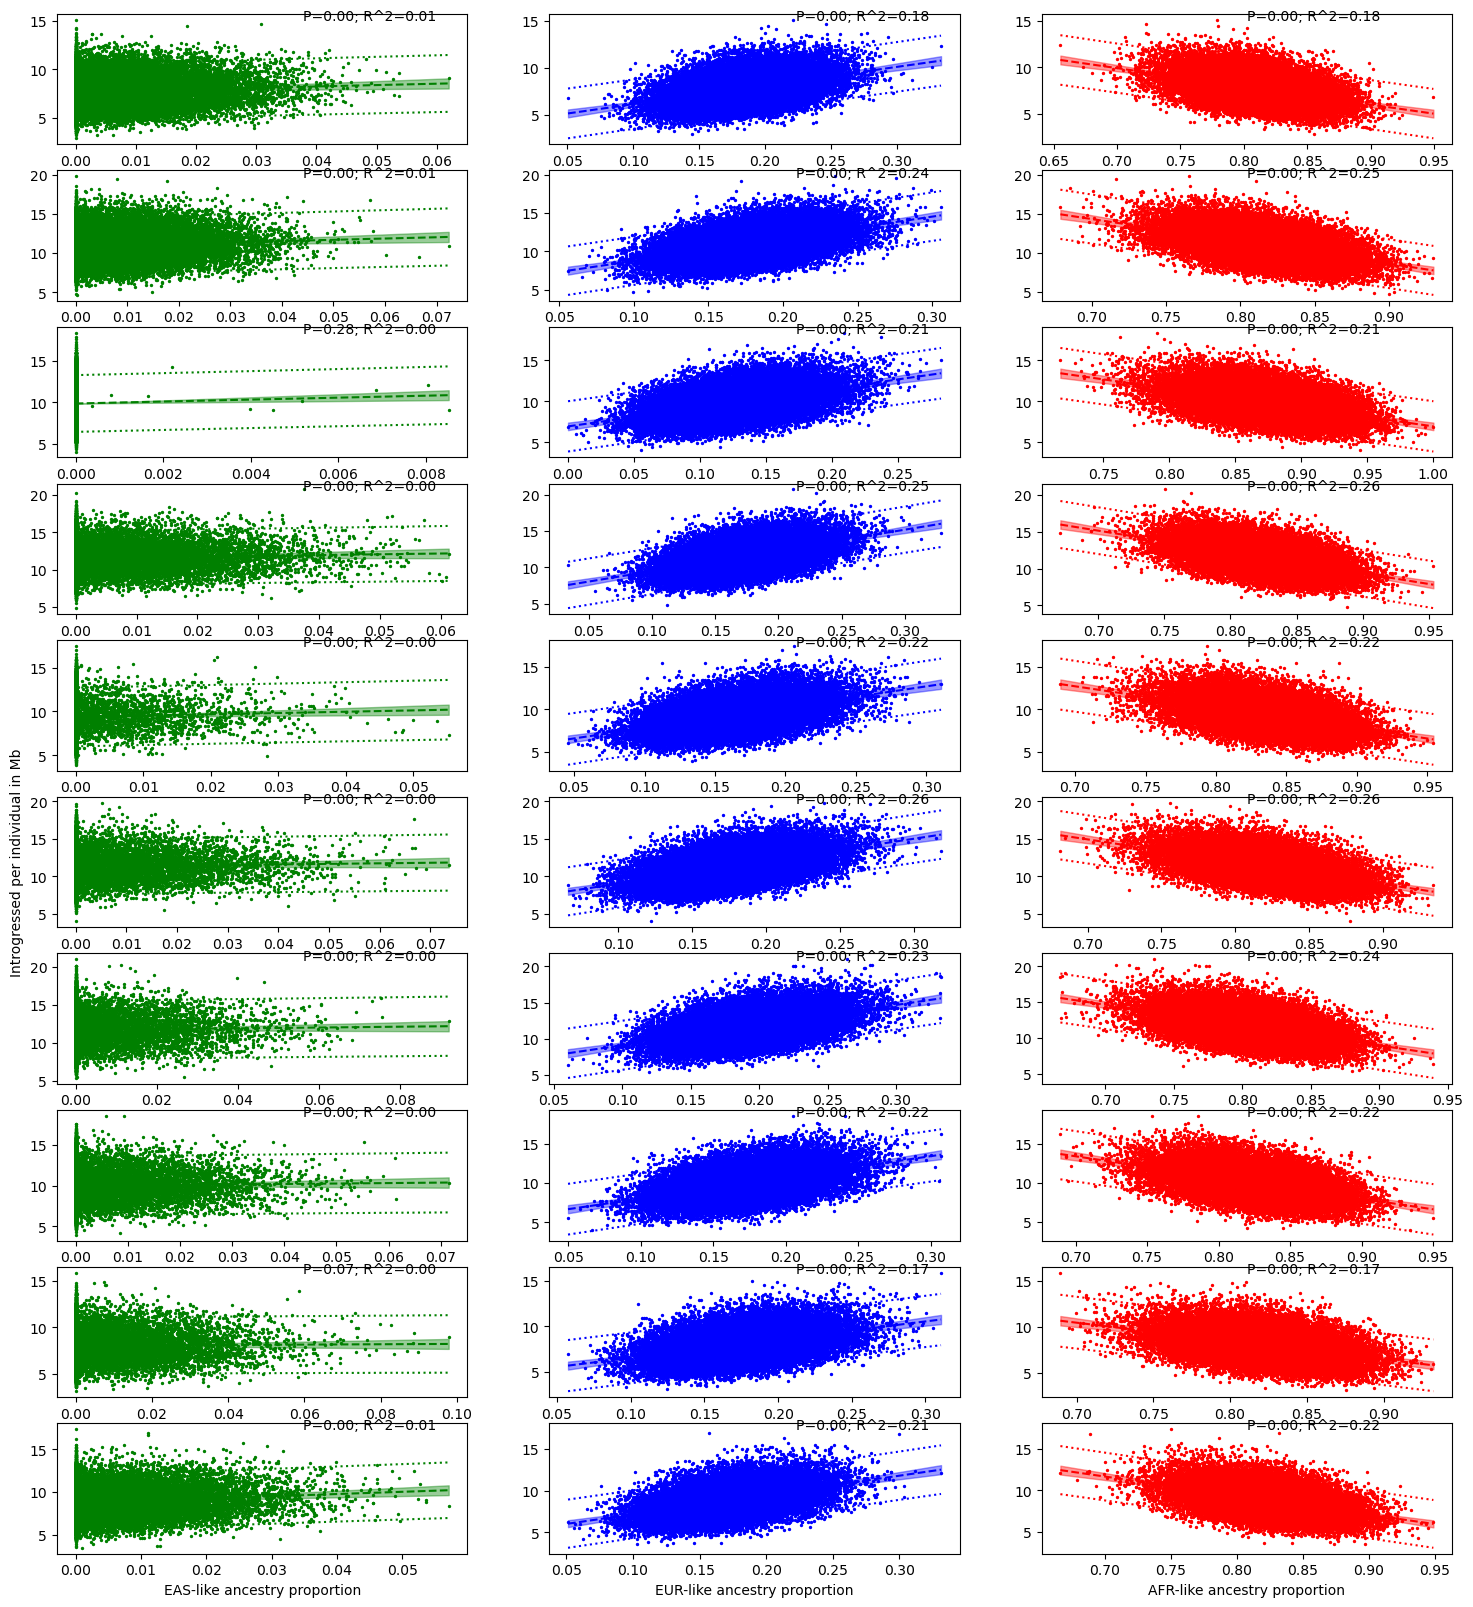

In [13]:
amounts_replicates = []
fig, ax = plt.subplots(replicates, 3, figsize=(18, 20))

for i, (df_sorted, introgressed_segments) in enumerate(zip(admixture_proportions_replicates, 
                                                           introgressed_segments_replicates)):
    if not 'African' in df_sorted.columns:
        df_sorted.rename({'AFR': 'African', 'EUR': 'European', 'EAS': 'EastAsian'}, axis=1, inplace=True)
    amounts = introgressed_segments.groupby('IID').sum().loc[:, ['length']] / 1e6
    amounts = df_sorted.join(amounts)
    amounts = amounts[amounts.population == 'AA']
    amounts.dropna(inplace=True)
    amounts_replicates.append(amounts)

    (slope_afr, intercept_afr, rval_afr, pval_afr, 
     x_model_afr, y_model_afr, ci_afr, pi_afr) = linear_regression(amounts.African, amounts['length'])
    try:
        (slope_eas, intercept_eas, rval_eas, pval_eas, 
         x_model_eas, y_model_eas, ci_eas, pi_eas) = linear_regression(amounts.EastAsian, amounts['length'])
    except ValueError:
        (slope_eas, intercept_eas, rval_eas, pval_eas, 
         x_model_eas, y_model_eas, ci_eas, pi_eas) = (0, 0, 0, 0, 0, 0, 0, 0)
    slope_eur, intercept_eur, rval_eur, pval_eur, x_model_eur, y_model_eur, ci_eur, pi_eur = linear_regression(amounts.European, amounts['length'])

    ax[i, 0].scatter(amounts.EastAsian, amounts['length'].values, color='green', s=2)
    ax[i, 0].plot(x_model_eas, y_model_eas, ls='--', color='green')
    try:
        ax[i, 0].fill_between(x_model_eas, y_model_eas + ci_eas, y_model_eas - ci_eas, color="green", alpha=0.4)
    except IndexError:
        pass
    ax[i, 0].annotate('P={:.2f}; R^2={:.2f}'.format(pval_eas, rval_eas ** 2), (1, 1), (0.6, 0.95),
                   xycoords='axes fraction')
    ax[i, 0].plot(x_model_eas, y_model_eas + pi_eas, ls=':', color='green')
    ax[i, 0].plot(x_model_eas, y_model_eas - pi_eas, ls=':', color='green')

    ax[i, 1].scatter(amounts.European, amounts['length'].values, color='blue', s=2)
    ax[i, 1].plot(x_model_eur, y_model_eur, ls='--', color='blue')
    ax[i, 1].fill_between(x_model_eur, y_model_eur + ci_eur, y_model_eur - ci_eur, color="blue", alpha=0.4)

    ax[i, 1].annotate('P={:.2f}; R^2={:.2f}'.format(pval_eur, rval_eur ** 2), (1, 1), (0.6, 0.95), 
                   xycoords='axes fraction')
    ax[i, 1].plot(x_model_eur, y_model_eur + pi_eur, ls=':', color='blue')
    ax[i, 1].plot(x_model_eur, y_model_eur - pi_eur, ls=':', color='blue')

    ax[i, 2].scatter(amounts.African, amounts['length'].values, color='red', s=2)
    
    ax[i, 2].plot(x_model_afr, y_model_afr, ls='--', color='red')
    ax[i, 2].fill_between(x_model_afr, y_model_afr + ci_afr, y_model_afr - ci_afr, color="red", alpha=0.4)
    ax[i, 2].annotate('P={:.2f}; R^2={:.2f}'.format(pval_afr, rval_afr ** 2), (1, 1), (0.5, 0.95), 
                   xycoords='axes fraction')
    ax[i, 2].plot(x_model_afr, y_model_afr + pi_afr, ls=':', color='red')
    ax[i, 2].plot(x_model_afr, y_model_afr - pi_afr, ls=':', color='red')

    ax[replicates // 2, 0].set_ylabel(f'Introgressed per individual in Mb')
    ax[replicates -1, 0].set_xlabel('EAS-like ancestry proportion')
    ax[replicates -1, 1].set_xlabel('EUR-like ancestry proportion')
    ax[replicates -1, 2].set_xlabel('AFR-like ancestry proportion')

### Introgression frequencies vs expected globally

Text(0, 0.5, 'Observed introgression amounts per indvidual in Mb')

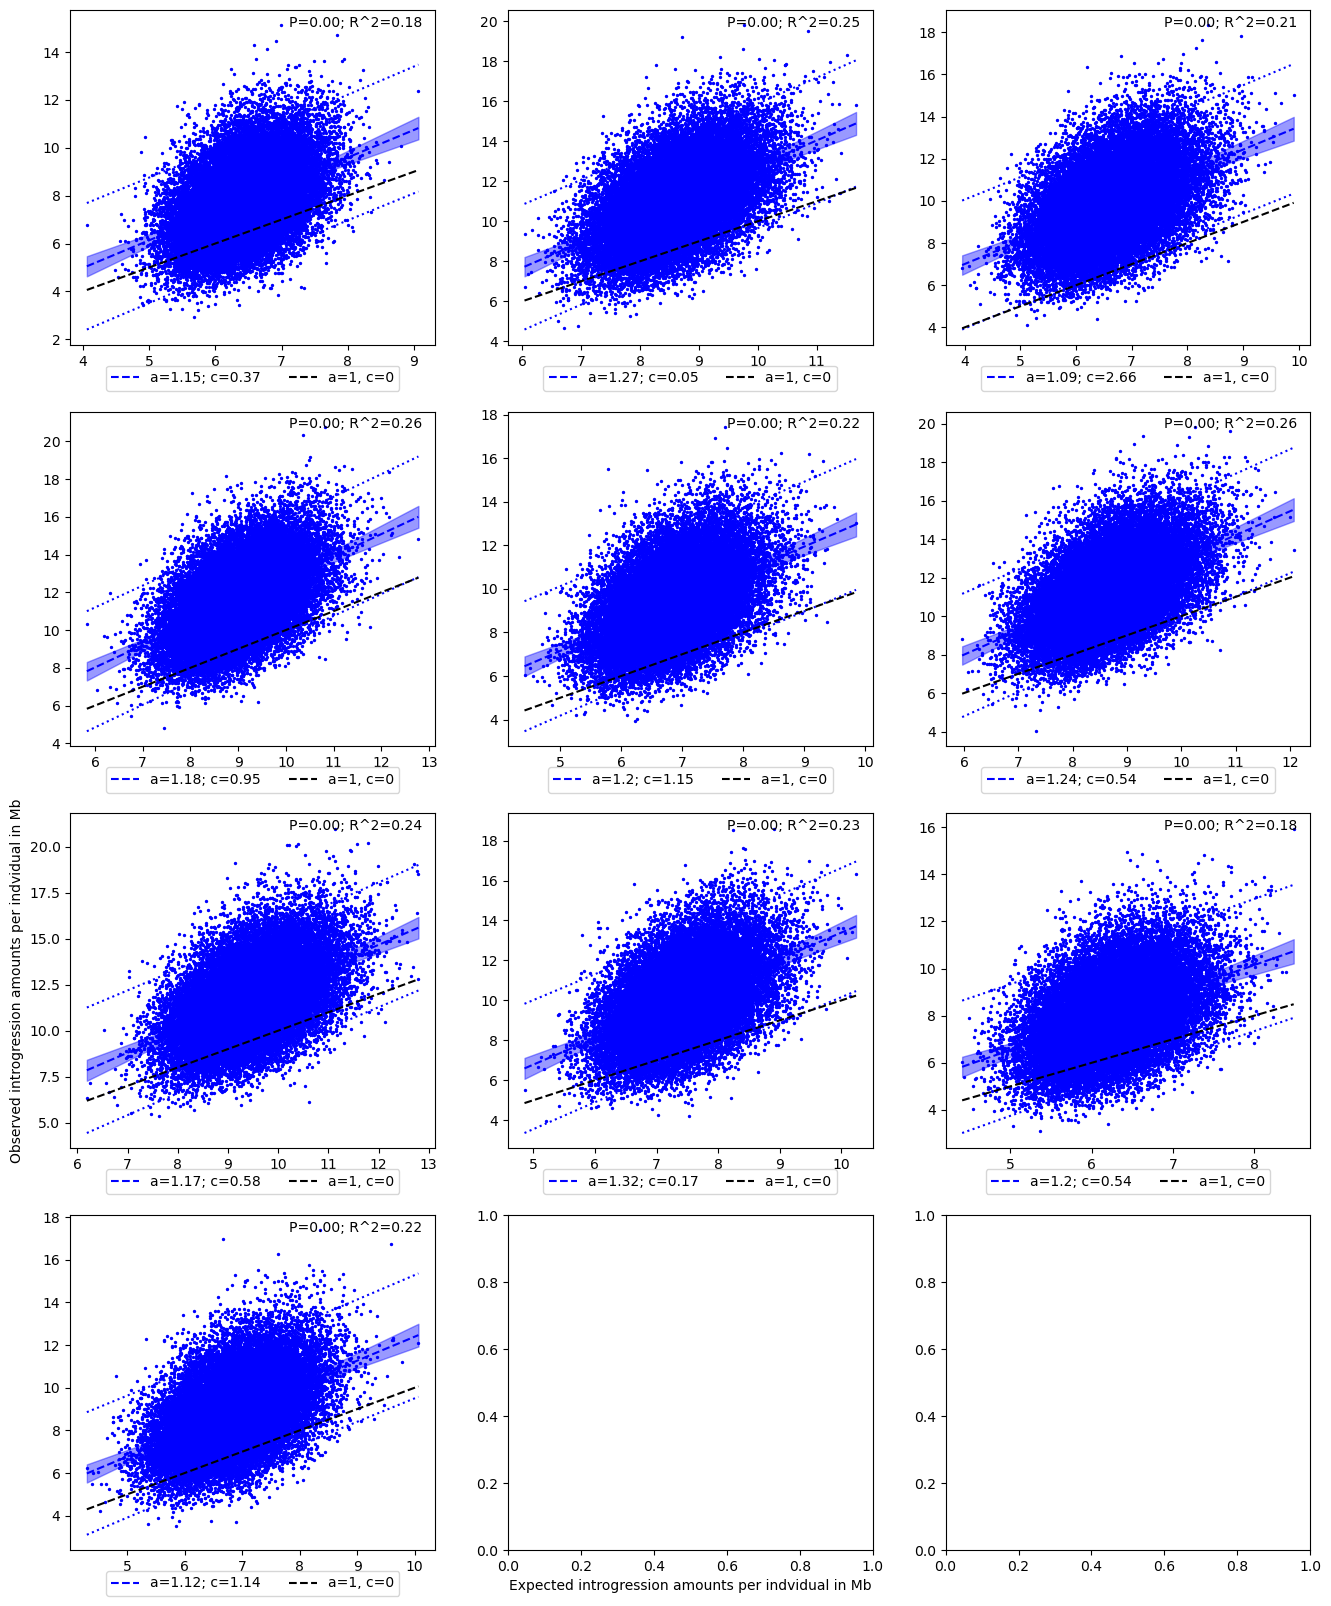

In [14]:
fig, ax = plt.subplots(np.ceil(replicates / 3).astype(int), 3, figsize=(16, 20))

for i, (amounts, introgressed_segments) in enumerate(zip(amounts_replicates, 
                                                         introgressed_segments_replicates)):
    pop_indv_mapping = introgressed_segments.drop_duplicates("IID").loc[:, ["IID", 'pop']].set_index('IID')
    amount_introgression_per_indv = introgressed_segments.loc[:, ['IID', 'length']].groupby('IID').sum() / 1e6
    amount_introgression_pop_per_indv = pop_indv_mapping.join(amount_introgression_per_indv)
    mean_introgression_per_pop = amount_introgression_pop_per_indv.groupby('pop').mean()
    amounts['expected_introgression'] = (amounts.African * mean_introgression_per_pop.loc['AFR', 'length'] + 
                                         amounts.European * mean_introgression_per_pop.loc['EUR', 'length'] +
                                         amounts.EastAsian * mean_introgression_per_pop.loc['EAS', 'length'])
    slope, intercept, rval, pval, x_model, y_model, ci, pi = linear_regression(amounts.expected_introgression, 
                                                                           amounts['length'])

    ax[i // 3, i % 3].scatter(amounts.expected_introgression.values, amounts['length'].values, c='blue', s=2)
    ax[i // 3, i % 3].plot(x_model, y_model, ls='--', color='blue', label=f'a={np.round(slope, 2)}; c={np.round(intercept, 2)}')
    ax[i // 3, i % 3].fill_between(x_model, y_model + ci, y_model - ci, color="blue", alpha=0.4)
    ax[i // 3, i % 3].plot(x_model, y_model + pi, ls=':', color='blue')
    ax[i // 3, i % 3].plot(x_model, y_model - pi, ls=':', color='blue')
    ax[i // 3, i % 3].annotate('P={:.2f}; R^2={:.2f}'.format(pval, rval ** 2), (1, 1), (0.6, 0.95),
                   xycoords='axes fraction')
    ax[i // 3, i % 3].plot(x_model, x_model, ls='--', c='black', label='a=1, c=0')
    ax[i // 3, i % 3].legend(bbox_to_anchor=(0.5, -.10), loc='center', ncol=2)
    
ax[np.ceil(replicates / 3).astype(int) - 1, 1].set_xlabel('Expected introgression amounts per indvidual in Mb')
ax[np.ceil(replicates / 3).astype(int) // 2, 0].set_ylabel('Observed introgression amounts per indvidual in Mb')

Text(0, 0.5, 'Observed introgression amounts per indvidual in Mb')

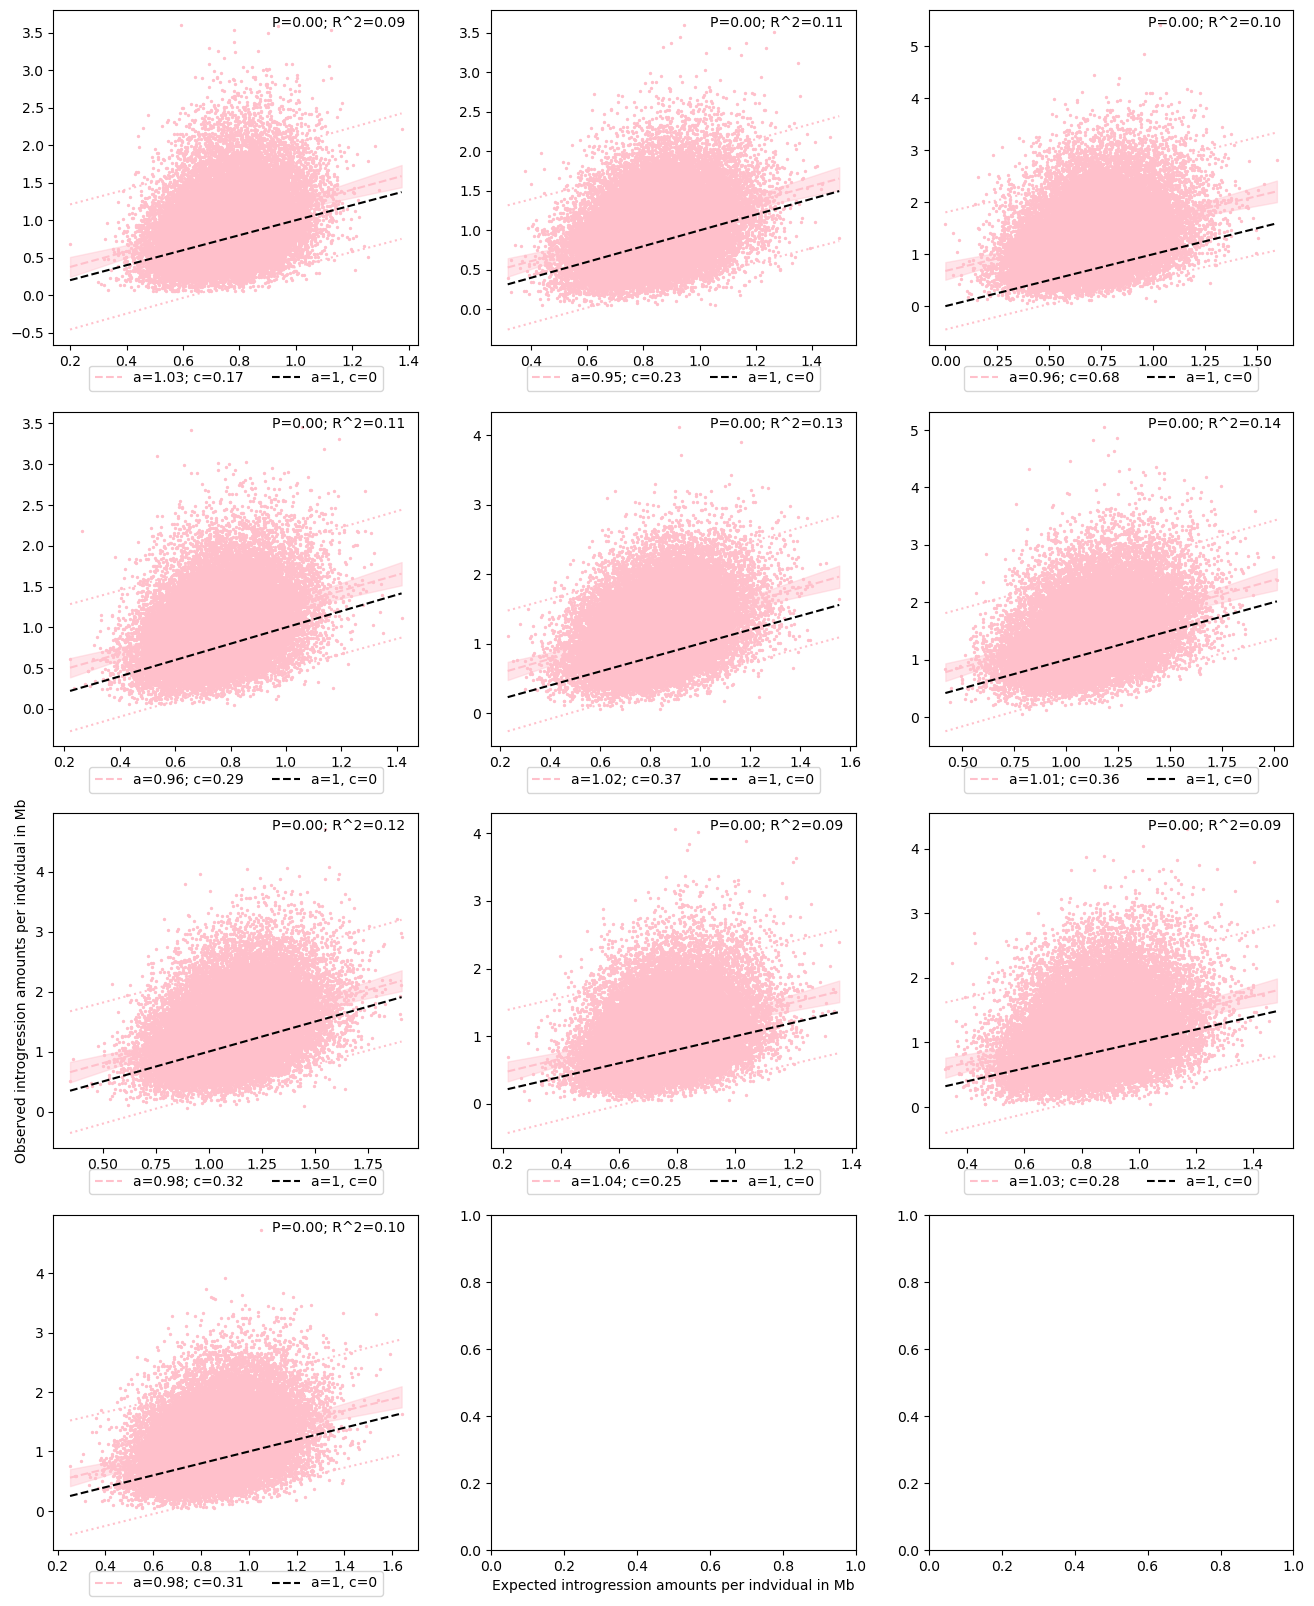

In [15]:
fig, ax = plt.subplots(np.ceil(replicates / 3).astype(int), 3, figsize=(16, 20))

for i, (df_super, introgressed_segments) in enumerate(zip(admixture_proportions_replicates, 
                                                         introgressed_segments_afr_masked_replicates)):
    if not 'African' in df_super.columns:
        df_super.rename({'AFR': 'African', 'EUR': 'European', 'EAS': 'EastAsian'}, axis=1, inplace=True)
    amounts_masked = introgressed_segments.groupby('IID').sum().loc[:, ['length']] / 1e6
    amounts_masked = amounts_masked.join(df_super)
    amounts_masked = amounts_masked[amounts_masked.population == 'AA']
    pop_indv_mapping = introgressed_segments.drop_duplicates("IID").loc[:, ["IID", 'pop']].set_index('IID')
    amount_introgression_per_indv = introgressed_segments.loc[:, ['IID', 'length']].groupby('IID').sum() / 1e6
    amount_introgression_pop_per_indv = pop_indv_mapping.join(amount_introgression_per_indv)
    mean_introgression_per_pop = amount_introgression_pop_per_indv.groupby('pop').mean()
    mean_introgression_per_pop.fillna(0, inplace=True)
    amounts_masked['expected_introgression'] = (amounts_masked.European * 
                                                mean_introgression_per_pop.loc['EUR', 'length'] +
                                                amounts_masked.EastAsian * 
                                                mean_introgression_per_pop.loc['EAS', 'length'])
    (slope, intercept, rval, pval, 
     x_model, y_model, ci, pi) = linear_regression(amounts_masked.expected_introgression,
                                                   amounts_masked['length'])

    ax[i // 3, i % 3].scatter(amounts_masked.expected_introgression.values, amounts_masked['length'].values, 
                              c='pink', s=2)
    ax[i // 3, i % 3].plot(x_model, y_model, ls='--', color='pink', 
                           label=f'a={np.round(slope, 2)}; c={np.round(intercept, 2)}')
    ax[i // 3, i % 3].fill_between(x_model, y_model + ci, y_model - ci, color="pink", alpha=0.4)
    ax[i // 3, i % 3].plot(x_model, y_model + pi, ls=':', color='pink')
    ax[i // 3, i % 3].plot(x_model, y_model - pi, ls=':', color='pink')
    ax[i // 3, i % 3].annotate('P={:.2f}; R^2={:.2f}'.format(pval, rval ** 2), (1, 1), (0.6, 0.95),
                   xycoords='axes fraction')
    ax[i // 3, i % 3].plot(x_model, x_model, ls='--', c='black', label='a=1, c=0')
    ax[i // 3, i % 3].legend(bbox_to_anchor=(0.5, -.10), loc='center', ncol=2)
    
ax[np.ceil(replicates / 3).astype(int) - 1, 1].set_xlabel('Expected introgression amounts per indvidual in Mb')
ax[np.ceil(replicates / 3).astype(int) // 2, 0].set_ylabel('Observed introgression amounts per indvidual in Mb')

### Load recombination filter

In [ ]:
fig, ax = plt.subplots(np.ceil(replicates / 3).astype(int), 3, figsize=(16, 20))

for i, (df_super, ibdmix) in enumerate(zip(admixture_proportions_replicates, 
                                           introgressed_segments_replicates)):
    if not 'African' in df_super.columns:
        df_super.rename({'AFR': 'African', 'EUR': 'European', 'EAS': 'EastAsian'}, axis=1, inplace=True)
    ibdmix_recomb = BedTool.from_dataframe(ibdmix).intersect(BedTool.from_dataframe(pass_rec_filter), 
                                                             f=1).to_dataframe(names=ibdmix.columns)
    amounts_recomb = ibdmix_recomb.groupby('IID').sum().loc[:, ['length']] / 1e6
    amounts_recomb = amounts_recomb.join(df_super)
    amounts_recomb = amounts_recomb[amounts_recomb.population == 'AA']
    super_pop_indv_mapping = ibdmix_recomb.drop_duplicates("IID").loc[:, ["IID", 'super_pop']].set_index('IID')
    amount_introgression_per_indv = ibdmix_recomb.loc[:, ['IID', 'length']].groupby('IID').sum() / 1e6
    amount_introgression_superpop_per_indv = super_pop_indv_mapping.join(amount_introgression_per_indv)
    mean_introgression_per_superpop = amount_introgression_superpop_per_indv.groupby('super_pop').mean()
    amounts_recomb['expected_introgression'] = (amounts_recomb.African * 
                                                mean_introgression_per_superpop.loc['AFR', 'length'] +
                                                amounts_recomb.European * 
                                                mean_introgression_per_superpop.loc['EUR', 'length'] +
                                                amounts_recomb.EastAsian * 
                                                mean_introgression_per_superpop.loc['EAS', 'length'])
    (slope, intercept, rval, pval, 
     x_model, y_model, ci, pi) = linear_regression(amounts_recomb.expected_introgression, 
                                                   amounts_recomb['length'])

    ax[i // 3, i % 3].scatter(amounts_recomb.expected_introgression.values, amounts_recomb['length'].values, 
                              c='orange', s=2)
    ax[i // 3, i % 3].plot(x_model, y_model, ls='--', color='orange', 
                           label=f'a={np.round(slope, 2)}; c={np.round(intercept, 2)}')
    ax[i // 3, i % 3].fill_between(x_model, y_model + ci, y_model - ci, color="orange", alpha=0.4)
    ax[i // 3, i % 3].plot(x_model, y_model + pi, ls=':', color='orange')
    ax[i // 3, i % 3].plot(x_model, y_model - pi, ls=':', color='orange')
    ax[i // 3, i % 3].annotate('P={:.2f}; R^2={:.2f}'.format(pval, rval ** 2), (1, 1), (0.6, 0.95),
                   xycoords='axes fraction')
    ax[i // 3, i % 3].plot(x_model, x_model, ls='--', c='black', label='a=1, c=0')
    ax[i // 3, i % 3].legend(bbox_to_anchor=(0.5, -.1), loc='center', ncol=2)    
ax[np.ceil(replicates / 3).astype(int) - 1, 1].set_xlabel('Expected introgression amounts per indvidual in Mb')
ax[np.ceil(replicates / 3).astype(int) // 2, 0].set_ylabel('Observed introgression amounts per indvidual in Mb')

### Apply both filters

Text(0, 0.5, 'Observed introgression amounts per indvidual in Mb')

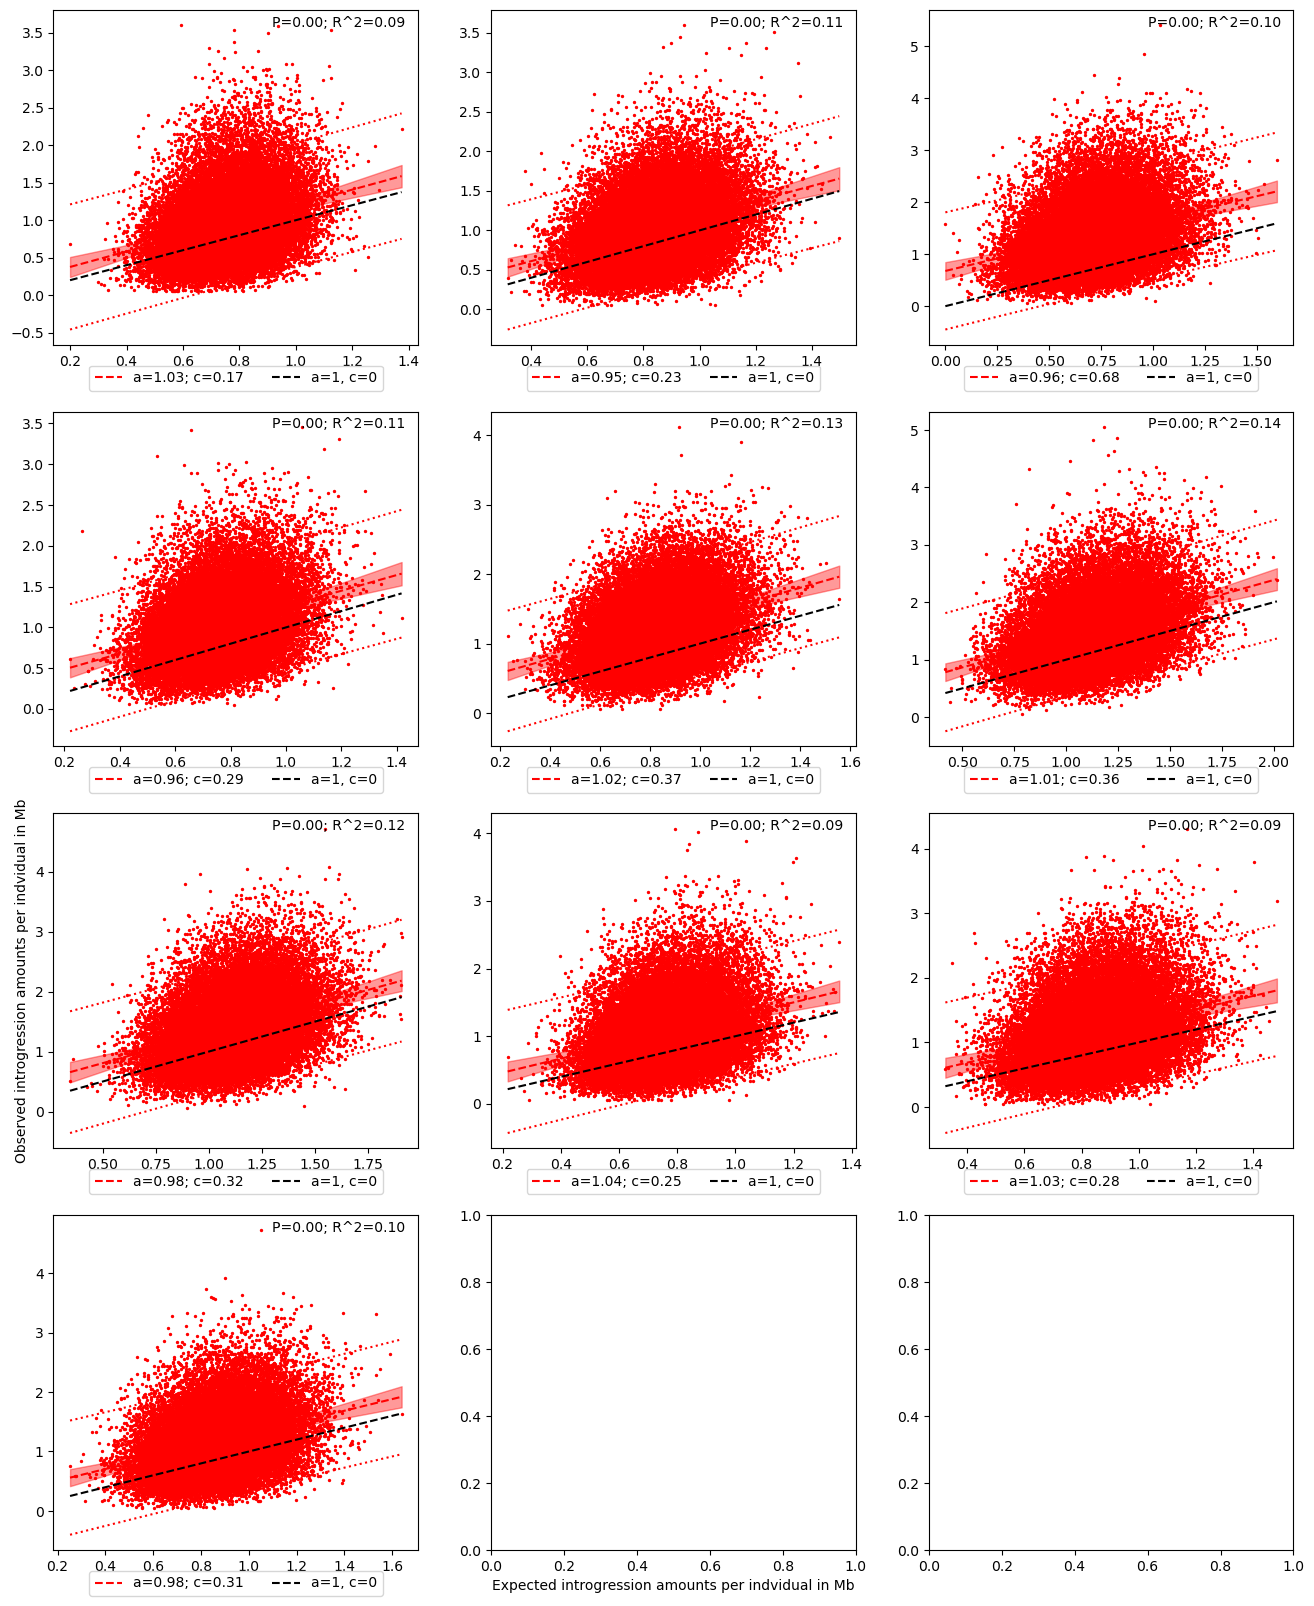

In [17]:
fig, ax = plt.subplots(np.ceil(replicates / 3).astype(int), 3, figsize=(16, 20))

for i, (df_super, ibdmix_masked) in enumerate(zip(admixture_proportions_replicates, 
                                                  introgressed_segments_afr_masked_replicates)):
    if not 'African' in df_super.columns:
        df_super.rename({'AFR': 'African', 'EUR': 'European', 'EAS': 'EastAsian'}, axis=1, inplace=True)
    ibdmix_masked_recomb = BedTool.from_dataframe(ibdmix_masked).intersect(BedTool.from_dataframe(pass_rec_filter), 
                                                             u=True).to_dataframe(names=ibdmix_masked.columns)
    amounts_masked_recomb = ibdmix_masked_recomb.groupby('IID').sum().loc[:, ['length']] / 1e6
    amounts_masked_recomb = amounts_masked_recomb.join(df_super)
    amounts_masked_recomb = amounts_masked_recomb[amounts_masked_recomb.population == 'AA']
    super_pop_indv_mapping = ibdmix_masked_recomb.drop_duplicates("IID").loc[:, ["IID", 'super_pop']].set_index('IID')
    amount_introgression_per_indv = ibdmix_masked_recomb.loc[:, ['IID', 'length']].groupby('IID').sum() / 1e6
    amount_introgression_superpop_per_indv = super_pop_indv_mapping.join(amount_introgression_per_indv)
    mean_introgression_per_superpop = amount_introgression_superpop_per_indv.groupby('super_pop').mean()
    amounts_masked_recomb['expected_introgression'] = (amounts_masked_recomb.European * 
                                                       mean_introgression_per_superpop.loc['EUR', 'length'] +
                                                       amounts_masked_recomb.EastAsian * 
                                                       mean_introgression_per_superpop.loc['EAS', 'length'])
    (slope, intercept, rval, pval, 
     x_model, y_model, ci, pi) = linear_regression(amounts_masked_recomb.expected_introgression, 
                                                   amounts_masked_recomb['length'])

    ax[i // 3, i % 3].scatter(amounts_masked_recomb.expected_introgression.values, 
                              amounts_masked_recomb['length'].values, 
                              c='red', s=2)
    ax[i // 3, i % 3].plot(x_model, y_model, ls='--', color='red', 
                           label=f'a={np.round(slope, 2)}; c={np.round(intercept, 2)}')
    ax[i // 3, i % 3].fill_between(x_model, y_model + ci, y_model - ci, color="red", alpha=0.4)
    ax[i // 3, i % 3].plot(x_model, y_model + pi, ls=':', color='red')
    ax[i // 3, i % 3].plot(x_model, y_model - pi, ls=':', color='red')
    ax[i // 3, i % 3].annotate('P={:.2f}; R^2={:.2f}'.format(pval, rval ** 2), (1, 1), (0.6, 0.95),
                   xycoords='axes fraction')
    ax[i // 3, i % 3].plot(x_model, x_model, ls='--', c='black', label='a=1, c=0')
    ax[i // 3, i % 3].legend(bbox_to_anchor=(0.5, -.1), loc='center', ncol=2)    
ax[np.ceil(replicates / 3).astype(int) - 1, 1].set_xlabel('Expected introgression amounts per indvidual in Mb')
ax[np.ceil(replicates / 3).astype(int) // 2, 0].set_ylabel('Observed introgression amounts per indvidual in Mb')

### Introgression frequencies vs expected locally

In [22]:
def find_significant_segments(df, enriched=False, depleted=False, min_length=90000, windowsize=50000, 
                              stride=10000):
    if enriched:
        df = df[df.freq > df.expectations].copy()
    elif depleted:
        df = df[df.freq < df.expectations].copy()
    df.reset_index(drop=True, inplace=True)
    if windowsize > stride:
        min_windows = int((min_length - windowsize) / stride + 1)
    elif windowsize == stride:
        min_windows = int(min_length / stride)
    idx_start = 0
    idx_end = 0
    differences = np.diff(df.start.values)
    to_keep = []
    for diff in differences:
        if diff == stride:
            idx_end += 1
        elif diff != stride and idx_end - idx_start >= min_windows:
            to_keep.append(np.arange(idx_start, idx_end + 1))
            idx_end += 1
            idx_start = idx_end
        else:
            idx_end += 1
            idx_start = idx_end
    if idx_end - idx_start >= min_windows:
        to_keep.append(np.arange(idx_start, idx_end + 1))
    if len(to_keep) > 0:
        to_keep = np.concatenate(to_keep)
        # need to trait pvalues differently
        columns = np.where((df.columns.values != 'probabilities') & (df.columns.values != 'corrected'))[0][3:] + 1
        merged = BedTool.from_dataframe(df.iloc[to_keep]).merge(c=columns.tolist(),
                                                                o='mean',
                                                                header=True)
        df.drop(['probabilities', 'corrected'], axis=1, inplace=True)
        merged = merged.to_dataframe(names=df.columns)
    else:
        merged = pd.DataFrame(columns=df.columns)
    return merged




def plot_frequencies_windows_helper(fn, n_indv, pass_rec_filter, ax, drift=False):
    introgression_freq_filtered = pd.read_csv(fn, sep='\t', header=0)
    introgression_freq_filtered['freq'] = introgression_freq_filtered.freq_updated
    introgression_freq_filtered.freq /= n_indv
    introgression_freq_filtered.freq_updated /= n_indv
    introgression_freq_filtered.expectations /= n_indv
#     introgression_freq_filtered = BedTool.from_dataframe(introgression_freq_filtered).intersect(
#         BedTool.from_dataframe(pass_rec_filter), f=1).to_dataframe(names=introgression_freq_filtered.columns)

    (slope, intercept, rval, pval, 
     x_model, y_model, ci, pi) = linear_regression(introgression_freq_filtered.expectations.values, 
                                                   introgression_freq_filtered.freq.values,
                                                   full_range=True)
    xlim = max([introgression_freq_filtered.expectations.max(),
                           introgression_freq_filtered.freq_updated.max()])
    if drift:

        significant = introgression_freq_filtered[(introgression_freq_filtered.corrected < 0.05) &
                                                  ((introgression_freq_filtered.freq_updated > 
                                                    introgression_freq_filtered.drift_upper) | 
                                                   (introgression_freq_filtered.freq_updated < 
                                                    introgression_freq_filtered.drift_lower))]
        non_significant = introgression_freq_filtered[(introgression_freq_filtered.corrected >= 0.05) |
                                                      ((introgression_freq_filtered.freq_updated >= 
                                                       introgression_freq_filtered.drift_lower) &
                                                      (introgression_freq_filtered.freq_updated <= 
                                                       introgression_freq_filtered.drift_upper))]
        sd_drift = lambda x: np.sqrt(x * (1 - x) * (1 - np.exp(-15 / 30000)))

        lower_bound = t.ppf(0.025 / introgression_freq_filtered.shape[0], 30780, 
                           loc=np.arange(0, xlim + 0.01, 0.0001), 
                            scale=sd_drift(np.arange(0, xlim + 0.01, 0.0001)))
        lower_bound = np.nan_to_num(np.where(lower_bound < 0, 0, lower_bound))
        upper_bound = t.ppf(1 - 0.025 / introgression_freq_filtered.shape[0], 30780, 
                            loc=np.arange(0, xlim + 0.01, 0.0001), 
                            scale=sd_drift(np.arange(0, xlim + 0.01, 0.0001)))
        upper_bound = np.nan_to_num(upper_bound)
        
        ax.plot(np.arange(0, xlim + 0.01, 0.0001), upper_bound, ls='--', color='grey')
        ax.plot(np.arange(0, xlim + 0.01, 0.0001), lower_bound, ls='--', color='grey')
    else:
        significant = introgression_freq_filtered[(introgression_freq_filtered.corrected < 0.05)]
        non_significant = introgression_freq_filtered[(introgression_freq_filtered.corrected >= 0.05)]
    print(introgression_freq_filtered.shape[0], significant.shape[0],
          significant[significant.freq_updated > significant.expectations].shape[0],
          significant[significant.freq_updated < significant.expectations].shape[0],
         )
        
        
    ax.scatter(non_significant.expectations.values, non_significant.freq_updated.values, color='gray', 
               s=2, label='p' + r'$\geq$' + '{:.2e}'.format(0.05/introgression_freq_filtered.shape[0]))
    ax.scatter(significant.loc[significant.freq_updated > significant.expectations, 'expectations'].values, 
               significant.loc[significant.freq_updated > significant.expectations, 'freq'].values, s=2,
               c='blue', 
               label='p < {:.2e}'.format(0.05/introgression_freq_filtered.shape[0]))
    ax.scatter(significant.loc[significant.freq_updated < significant.expectations, 'expectations'].values, 
               significant.loc[significant.freq_updated < significant.expectations, 'freq'].values, s=2, 
               c='red', 
               label='p < {:.2e}'.format(0.05/introgression_freq_filtered.shape[0]))

    ax.plot(x_model, x_model, ls='--', c='black', label=f'a=1; c=0')

    ax.set_xlabel("Expected introgression frequency")
    ax.set_ylabel("Observed introgression frequency")
    ax.set_aspect('equal')
    ax.set_xlim([0.0, xlim + 0.01])
    ax.set_ylim([0.0, xlim + 0.01])
    inset = ax.inset_axes([0.55, 0.05, 0.4, 0.4], xlim=(0, 0.02), ylim=(0, 0.02),
                          yticklabels=[], xticklabels=[], xticks=np.arange(0, 0.03, 0.01),
                          yticks=np.arange(0, 0.03, 0.01))
    inset.scatter(non_significant.expectations.values, non_significant.freq.values, color='gray', s=2)
    inset.scatter(significant.loc[significant.freq > significant.expectations, 'expectations'].values, 
                  significant.loc[significant.freq > significant.expectations, 'freq'].values, s=2, c='blue', 
                  label='p < {:.2e}'.format(0.05/introgression_freq_filtered.shape[0]))
    inset.scatter(significant.loc[significant.freq < significant.expectations, 'expectations'].values, 
                  significant.loc[significant.freq < significant.expectations, 'freq'].values, s=2, c='red', 
                  label='p < {:.2e}'.format(0.05/introgression_freq_filtered.shape[0]))
    inset.plot(x_model, x_model, ls='--', c='black')
    if drift:
        inset.plot(np.arange(0, xlim + 0.01, 0.0001), upper_bound, ls='--', color='grey')
        inset.plot(np.arange(0, xlim + 0.01, 0.0001), lower_bound, ls='--', color='grey')
    ax.indicate_inset_zoom(inset, edgecolor="black")
    return ax, introgression_freq_filtered

def get_differences_in_introgression_freqs(fn, n_indv):
    introgression_freq_filtered = pd.read_csv(fn, sep='\t', header=0)
    introgression_freq_filtered['freq'] = introgression_freq_filtered.freq_updated
    introgression_freq_filtered.freq /= n_indv
    introgression_freq_filtered.freq_updated /= n_indv
    introgression_freq_filtered.expectations /= n_indv
    return (introgression_freq_filtered.freq_updated.values - 
            introgression_freq_filtered.expectations.values, 
            introgression_freq_filtered.freq_updated.values, 
            introgression_freq_filtered.expectations.values)

/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


3067 66 63 3


/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/stor

3846 57 57 0
3755 57 57 0
4102 92 92 0


/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


3818 90 82 8
4334 102 80 22


/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/stor

4092 123 108 15
3451 96 96 0
3091 105 95 10


/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/storage/home/hcoda1/3/apfennig3/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


3302 66 66 0


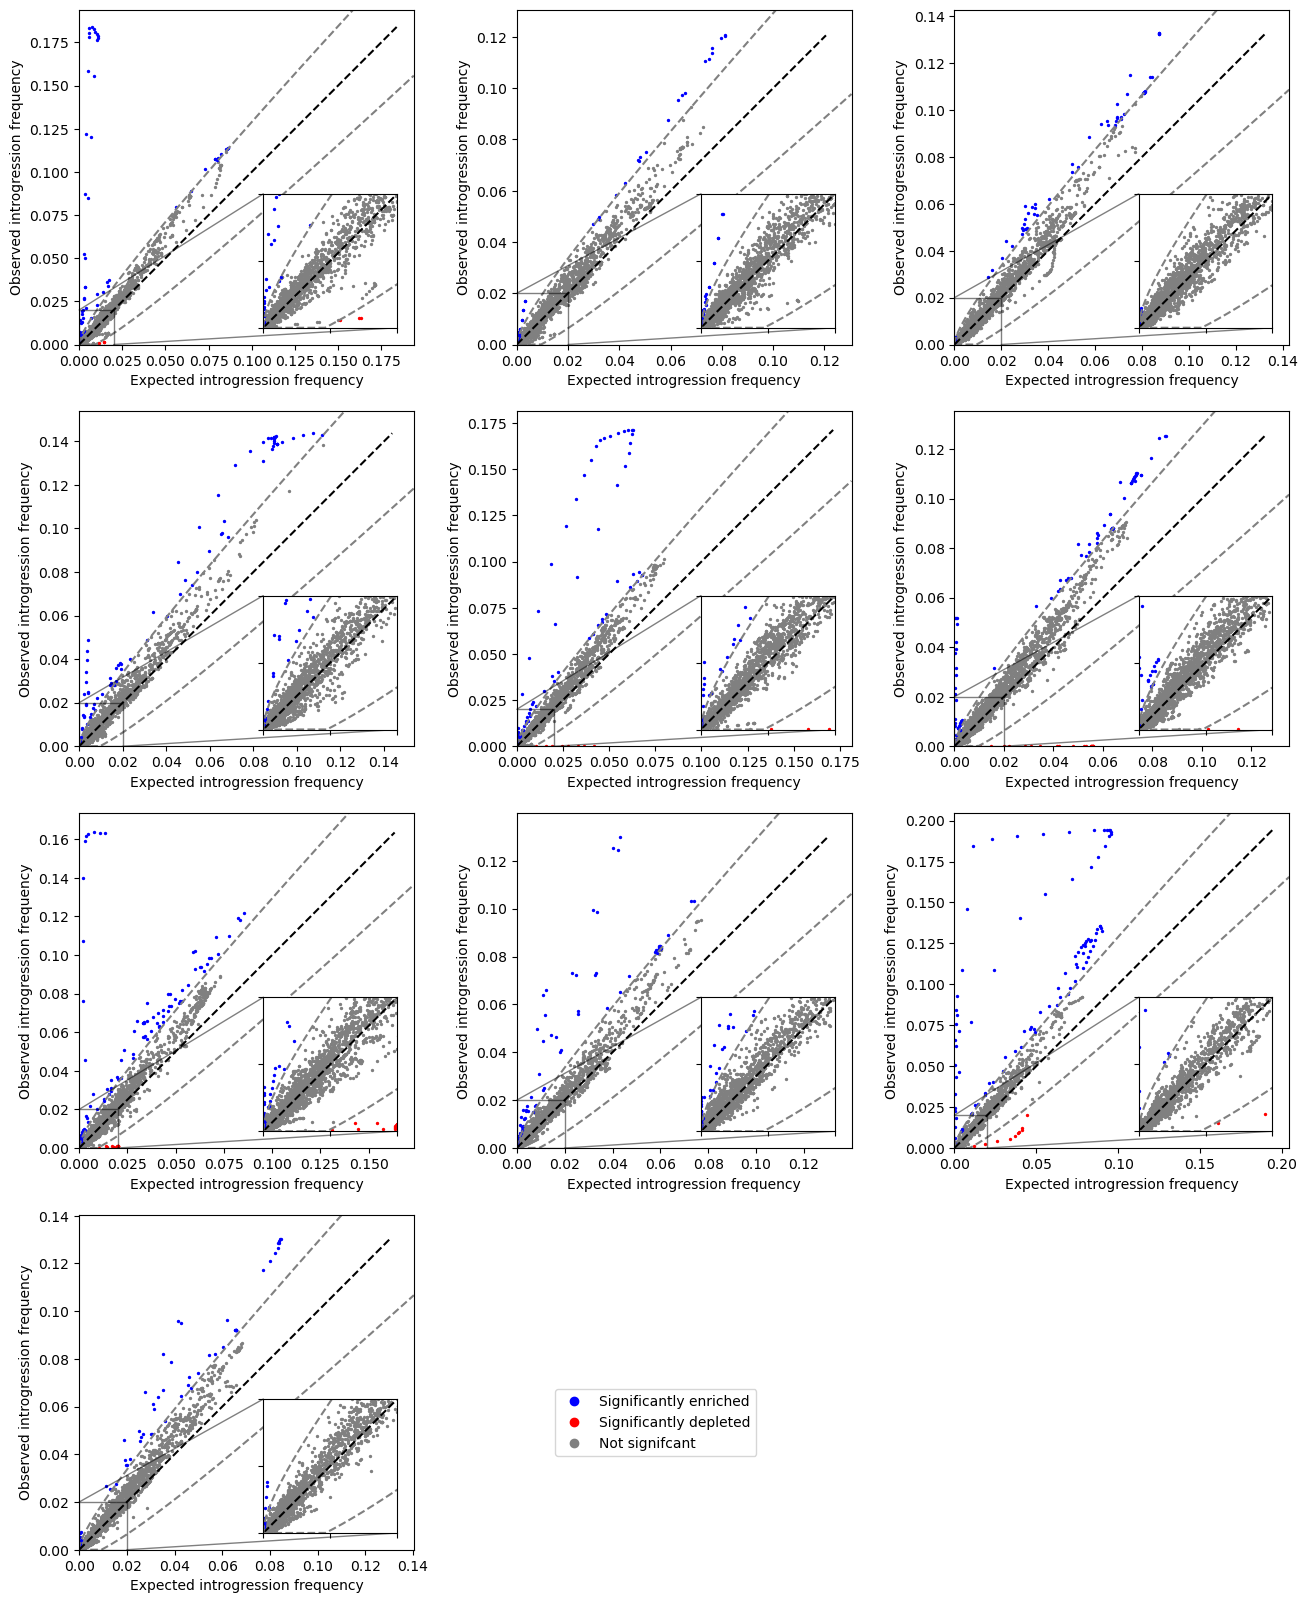

In [23]:
fig, ax = plt.subplots(np.ceil(replicates / 3).astype(int), 3, figsize=(16, 20))
introgression_freq_filtered_replicates = []
introgression_freq_differences = []
observed = []
expected = []
# apply filters
drift = True
for i in range(replicates):
    _, introgression_freq_filtered = plot_frequencies_windows_helper(
        f'simulations_exp_ref/neanderthal_introgressed_segments_masked_denisovan_replicate_{i}_afr_masked_coverage_per_individual_and_per_window50000_s_10000_pvalues.bed',
        30780, pass_rec_filter, ax[i // 3, i % 3], drift=drift)
    diff, obs, exp = get_differences_in_introgression_freqs(f'simulations_exp_ref/neanderthal_introgressed_segments_masked_denisovan_replicate_{i}_afr_masked_coverage_per_individual_and_per_window50000_s_10000_pvalues.bed',
                                                            30780)
    introgression_freq_filtered_replicates.append(introgression_freq_filtered)
    introgression_freq_differences.append(diff)
    observed.append(obs)
    expected.append(exp)
if drift:
    handles = [Line2D([0], [0], marker='o', ls='', color='blue', 
                      label='Significantly enriched'),
           Line2D([0], [0], marker='o', ls='', color='red', 
                  label='Significantly depleted'),
           Line2D([0], [0], marker='o', ls='', color='grey', 
                  label='Not signifcant')]
else:
    handles = [Line2D([0], [0], marker='o', ls='', color='blue', label='Enriched (p < 0.05/n)'),
               Line2D([0], [0], marker='o', ls='', color='red', label='Depleted (p < 0.05/n)'),
               Line2D([0], [0], marker='o', ls='', color='grey', label='p ' + r'$\geq$' + ' 0.05/n')]
ax[i // 3, i % 3].legend(handles=handles, ncol=1, bbox_to_anchor=(1.4, 0.5))
ax[i // 3, 1].remove()
ax[i // 3, 2].remove()
if drift:
    fig.savefig('visualizations/simulations_frequencies_windows50kb_drift.png', bbox_inches='tight', dpi=600)
    fig.savefig('visualizations/simulations_frequencies_windows50kb_drift.pdf', bbox_inches='tight', dpi=600)
else:
    fig.savefig('visualizations/simulations_frequencies_windows50kb.png', bbox_inches='tight', dpi=600)
    fig.savefig('visualizations/simulations_frequencies_windows50kb.pdf', bbox_inches='tight', dpi=600)

In [24]:
simulated_introgression_freq_filtered = pd.concat(introgression_freq_filtered_replicates).sort_values(
    ['chrom', 'start', 'end'])
simulated_introgression_freq_filtered.to_csv('simulated_introgression_freq_filtered.bed', sep='\t', header=True)

In [25]:
np.savez(f'simulations_freq_differences_50kb_windows.npz', 
         np.array(introgression_freq_differences, dtype=object))